In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, UpSampling2D, BatchNormalization, SpatialDropout2D, Input, MaxPool2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import vgg16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.data import Dataset, AUTOTUNE
import tensorflow.strings
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt

from glob import glob
from pathlib import Path
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
PATH_TO_TRAINING = r'../input/drishtigs-retina-dataset-for-onh-segmentation/Training-20211018T055246Z-001/Training/'
PATH_TO_TRAINING_TENSOR = tf.Variable(PATH_TO_TRAINING)

TRAIN_GLAUCOMA_IMAGES = np.array(glob(os.path.join(PATH_TO_TRAINING, 'Images/GLAUCOMA/*')))
TRAIN_NORMAL_IMAGES = np.array(glob(os.path.join(PATH_TO_TRAINING, 'Images/NORMAL/*')))

TRAIN_GLAUCOMA_GT = np.array(glob(PATH_TO_TRAINING + '/GT/GALUCOMA/*'))
TRAIN_NORMAL_GT = np.array(glob(PATH_TO_TRAINING + '/GT/NORMAL/*'))

PATH_TO_TEST = r'../input/drishtigs-retina-dataset-for-onh-segmentation/Test-20211018T060000Z-001/Test'
TEST_GLAUCOMA_IMAGES = np.array(glob(os.path.join(PATH_TO_TEST, 'Images/glaucoma/*')))
TEST_NORMAL_IMAGES = np.array(glob(os.path.join(PATH_TO_TEST, 'Images/normal/*')))

SEED = 2
EPSILON = 10 ** -4
STATELESS_RNG= tf.random.Generator.from_seed(SEED, alg='philox')
IMAGE_SIZE = (224, 224)
CHANNELS = 3
SHUFFLE_BUFFER = len(TRAIN_NORMAL_IMAGES) + len(TRAIN_GLAUCOMA_IMAGES)
BATCH_SIZE = SHUFFLE_BUFFER // 2
early_stopping = EarlyStopping(monitor = 'val_loss', restore_best_weights = True, patience = 5)

In [3]:
#.stem ===> instead of image1.jpg
Path(TRAIN_GLAUCOMA_IMAGES[0]).stem
TEST_GLAUCOMA_IMAGES

array(['../input/drishtigs-retina-dataset-for-onh-segmentation/Test-20211018T060000Z-001/Test/Images/glaucoma/drishtiGS_054.png',
       '../input/drishtigs-retina-dataset-for-onh-segmentation/Test-20211018T060000Z-001/Test/Images/glaucoma/drishtiGS_048.png',
       '../input/drishtigs-retina-dataset-for-onh-segmentation/Test-20211018T060000Z-001/Test/Images/glaucoma/drishtiGS_071.png',
       '../input/drishtigs-retina-dataset-for-onh-segmentation/Test-20211018T060000Z-001/Test/Images/glaucoma/drishtiGS_006.png',
       '../input/drishtigs-retina-dataset-for-onh-segmentation/Test-20211018T060000Z-001/Test/Images/glaucoma/drishtiGS_079.png',
       '../input/drishtigs-retina-dataset-for-onh-segmentation/Test-20211018T060000Z-001/Test/Images/glaucoma/drishtiGS_003.png',
       '../input/drishtigs-retina-dataset-for-onh-segmentation/Test-20211018T060000Z-001/Test/Images/glaucoma/drishtiGS_083.png',
       '../input/drishtigs-retina-dataset-for-onh-segmentation/Test-20211018T060000Z-001/T

In [4]:
def load_image_and_gt(path, test = False):
    '''
    Takes a path to the image,
    and returns the image alongside
    its ground truth
    '''
    
    print(path)
    
    filename = Path(path).stem
    if test:
        path_to_OD_softmap = os.path.join(PATH_TO_TEST, 'Test_GT', filename, 'SoftMap', filename + '_ODsegSoftmap.png')
        path_to_cup_softmap = os.path.join(PATH_TO_TEST, 'Test_GT', filename, 'SoftMap', filename + '_cupsegSoftmap.png')    
    else:
        path_to_OD_softmap = os.path.join(PATH_TO_TRAINING, 'GT', filename, 'SoftMap', filename + '_ODsegSoftmap.png')
        path_to_cup_softmap = os.path.join(PATH_TO_TRAINING, 'GT', filename, 'SoftMap', filename + '_cupsegSoftmap.png')
    image = tf.io.read_file(path)
    image = tf.io.decode_png(image)
    od = tf.io.read_file(path_to_OD_softmap)
    od = tf.io.decode_png(od)
    cup = tf.io.read_file(path_to_cup_softmap)
    cup = tf.io.decode_png(cup)
    return image, od, cup

def show_image_with_masks(image, od, cup, ax, index, label):
    '''
    Plots the real world image
    And the two masks
    Also shows the image after
    being masked with each mask
    Requires len(ax) >= 5
    '''
    ax[5 * index].imshow(image)
    ax[5 * index].set_title(label)
    ax[5 * index + 1].imshow(od)
    ax[5 * index + 1].set_title('Optical Disk Mask')
    ax[5 * index + 2].imshow(od * image)
    ax[5 * index + 2].set_title('Image with OD Mask')
    ax[5 * index + 3].imshow(cup)
    ax[5 * index + 3].set_title('Cup Mask')
    ax[5 * index + 4].imshow(cup * image)
    ax[5 * index + 4].set_title('Image with CUP Mask')
    
def load_image_with_masks(path, dice = False, test = False):
    '''
    This is similar to the
    load image_with_gt function
    however uses pure tf functions
    for the use in datasets
    otherwise I'd have to run
    in eagerexecution
    '''
    
    filename = tf.strings.split(path, sep = '.')[-2]
    filename = tf.strings.split(filename, sep = '/')[-1]
    directory_path = tf.strings.split(path, sep = 'Images')[0]
    if test:
        softmap_path = tf.strings.join([directory_path, 'Test_GT/', filename, '/SoftMap/'])
    else:
        softmap_path = tf.strings.join([directory_path, 'GT/', filename, '/SoftMap/'])
    od_path = tf.strings.join([softmap_path, filename, '_ODsegSoftmap.png'])
    cup_path = tf.strings.join([softmap_path, filename, '_cupsegSoftmap.png'])
    image = tf.io.read_file(path)
    image = tf.io.decode_png(image, channels = 3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = image / 255.0
    
    od = tf.io.read_file(od_path)
    od = tf.io.decode_png(od, channels = 1)
    od = tf.image.resize(od, IMAGE_SIZE)
    od = od / 255.0
    if dice:
        od = tf.where(od >= 0.5, 1.0, 0.0)
    
    cup = tf.io.read_file(cup_path)
    cup = tf.io.decode_png(cup, channels = 1)
    cup = tf.image.resize(cup, IMAGE_SIZE)
    cup = cup / 255.0
    if dice:
        cup = tf.where(cup >= 0.5, 1.0, 0.0)
    
    return {'image' : image}, {'od' : od, 'cup' : cup}

def augment_images(image, od, cup, single_target = False):
    
    seeds = STATELESS_RNG.make_seeds(2)[0], STATELESS_RNG.make_seeds(2)[0]
    
    def augment(img, seeds):
        
        img = tf.image.stateless_random_flip_left_right(img, seeds[0])
        img = tf.image.stateless_random_flip_up_down(img, seeds[1])
        img = tf.image.resize_with_crop_or_pad(img, IMAGE_SIZE[0] + 20, IMAGE_SIZE[1] + 20)
        img = tf.image.stateless_random_crop(img, size = (*IMAGE_SIZE, img.shape[2]), seed = seeds[0])
        
        return img
    
    image = augment(image, seeds)
    od = augment(od, seeds)
    cup = augment(cup, seeds)
    
    if single_target:
        return image, od
    return {'image' : image}, {'od' : od, 'cup' : cup}

../input/drishtigs-retina-dataset-for-onh-segmentation/Training-20211018T055246Z-001/Training/Images/NORMAL/drishtiGS_042.png


TensorShape([1750, 2050, 3])

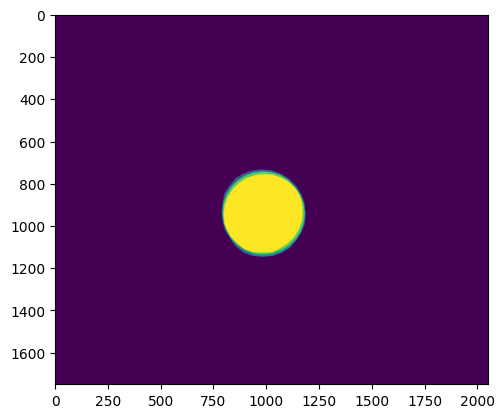

In [5]:
image, od, cup = load_image_and_gt(TRAIN_NORMAL_IMAGES[0])
plt.imshow(od)
image.shape

../input/drishtigs-retina-dataset-for-onh-segmentation/Training-20211018T055246Z-001/Training/Images/NORMAL/drishtiGS_017.png
../input/drishtigs-retina-dataset-for-onh-segmentation/Training-20211018T055246Z-001/Training/Images/NORMAL/drishtiGS_035.png
../input/drishtigs-retina-dataset-for-onh-segmentation/Training-20211018T055246Z-001/Training/Images/NORMAL/drishtiGS_089.png
../input/drishtigs-retina-dataset-for-onh-segmentation/Training-20211018T055246Z-001/Training/Images/GLAUCOMA/drishtiGS_038.png
../input/drishtigs-retina-dataset-for-onh-segmentation/Training-20211018T055246Z-001/Training/Images/GLAUCOMA/drishtiGS_012.png
../input/drishtigs-retina-dataset-for-onh-segmentation/Training-20211018T055246Z-001/Training/Images/GLAUCOMA/drishtiGS_088.png


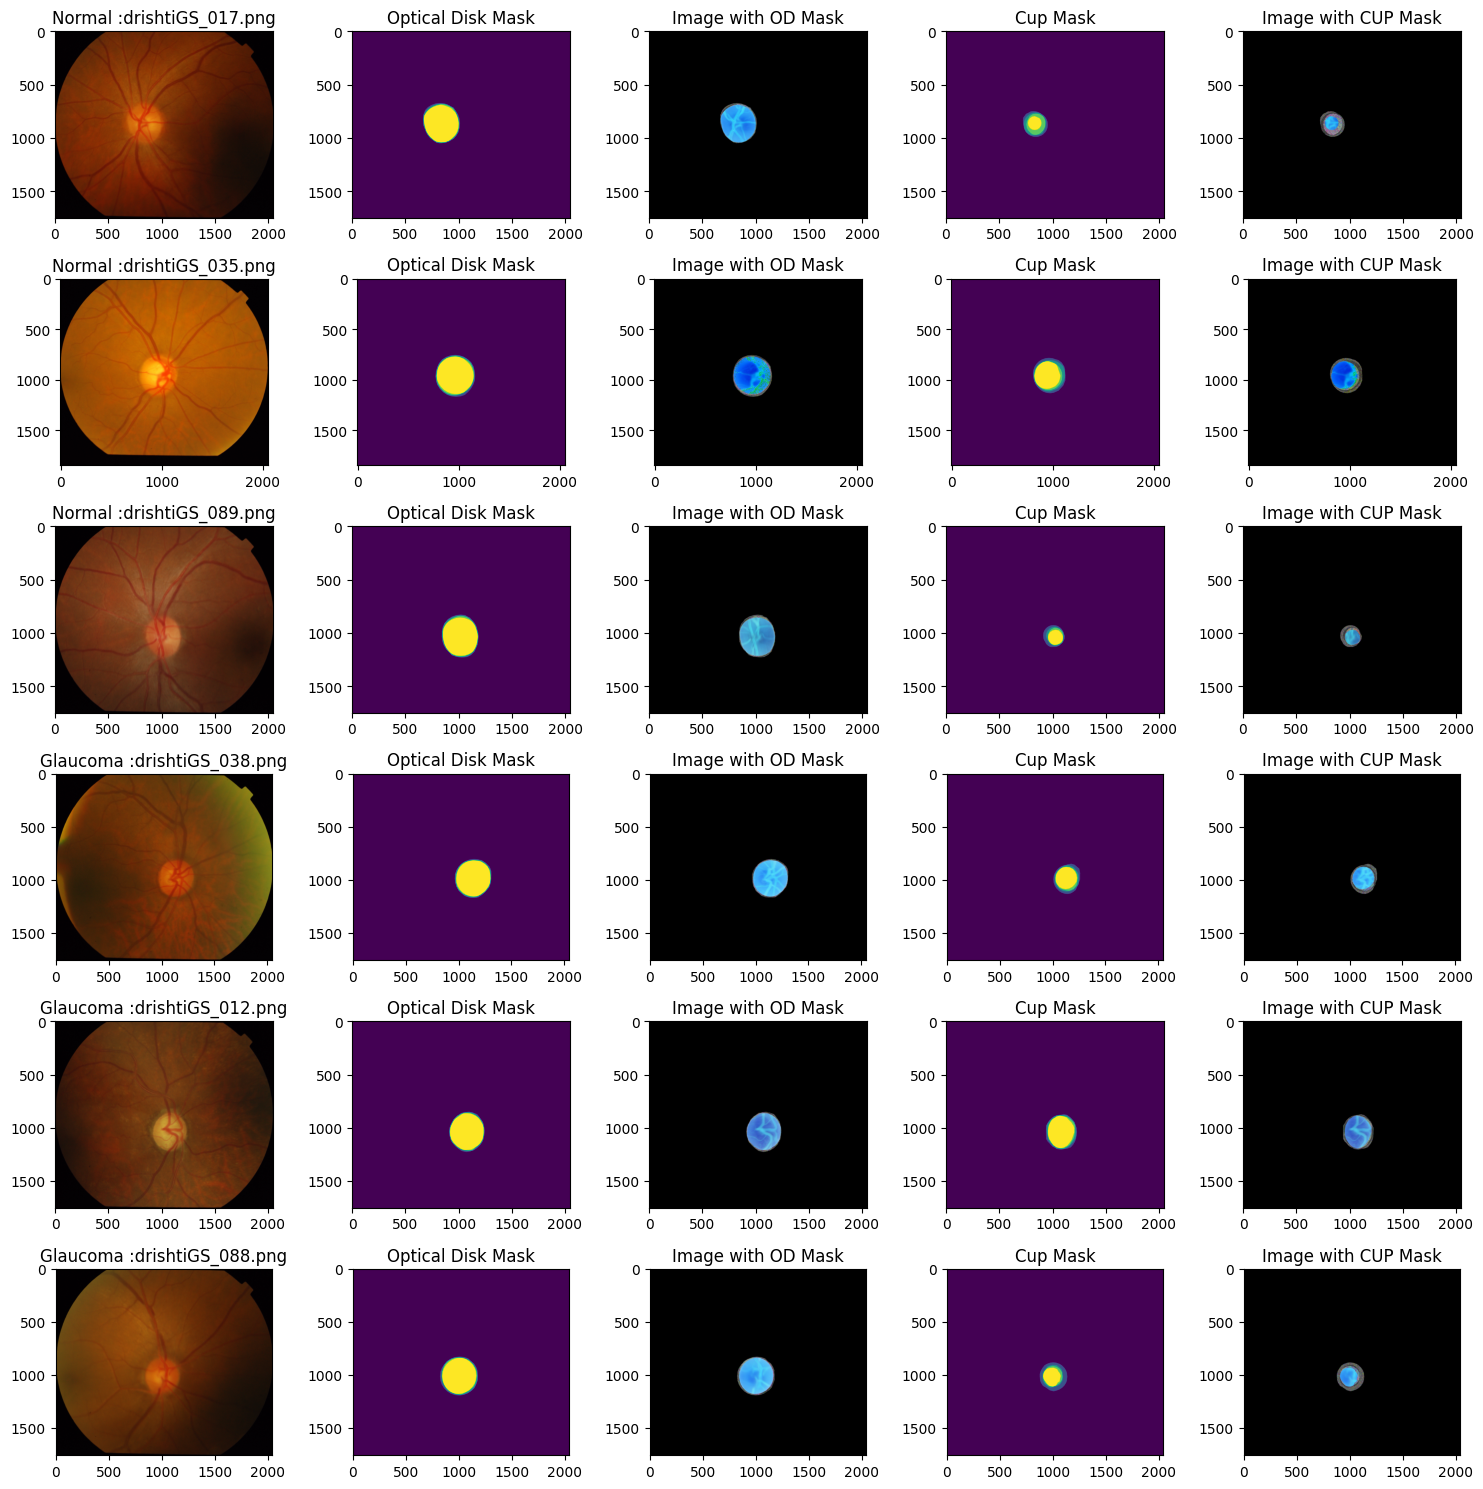

In [6]:
rows = 6
cols = 5
fig, axes = plt.subplots(rows, cols, figsize = (15, 15))
axes = axes.flatten()

normal_images = np.random.choice(TRAIN_NORMAL_IMAGES, rows // 2)
glaucoma_images = np.random.choice(TRAIN_GLAUCOMA_IMAGES, rows - (rows // 2))

for idx, file in enumerate(normal_images):
    image, od, cup = load_image_and_gt(file)
    show_image_with_masks(image, od, cup, axes, index = idx, label = 'Normal :' + os.path.basename(file))
    
for idx, file in enumerate(glaucoma_images):
    image, od, cup = load_image_and_gt(file)
    show_image_with_masks(image, od, cup, axes, index = idx + rows // 2, label = 'Glaucoma :' + os.path.basename(file))

plt.tight_layout()

In [7]:
def get_avgboundary(file):
    image = tf.io.read_file(file)
    image = tf.io.decode_png(image)
    
    cup_mask = np.zeros(shape = (image.shape[0], image.shape[1]))
    od_mask = np.zeros(shape = (image.shape[0], image.shape[1]))
    center_mask = np.zeros(shape = (image.shape[0], image.shape[1]))
    
    filename = Path(file).stem
    boundary_path = os.path.join(PATH_TO_TRAINING, 'GT', filename, 'AvgBoundary')
    cup_file = os.path.join(boundary_path, filename + '_CupAvgBoundary.txt')
    od_file = os.path.join(boundary_path, filename + '_ODAvgBoundary.txt')
    center_file = os.path.join(boundary_path, filename + '_diskCenter.txt')
    
    count = 0
    with open(cup_file) as cf:
        for line in cf:
            a, b = line.split()
            a = int(a)
            b = int(b)
            cup_mask[a, b] = 255
            count += 1

    with open(od_file) as of:
        for line in of:
            a, b = line.split()
            a = int(a)
            b = int(b)
            od_mask[a, b] = 255
        
    with open(center_file) as ctrf:
        for line in ctrf:
            a, b = line.split()
            a = int(a)
            b = int(b)
            center_mask[a, b] = 255
    return od_mask.reshape(image.shape[0], image.shape[1], 1), \
cup_mask.reshape(image.shape[0], image.shape[1], 1), center_mask.reshape(image.shape[0], image.shape[1], 1)

In [8]:
glaucoma_avgboundary_test = TRAIN_GLAUCOMA_IMAGES[3]

od_mask, cup_mask, center_mask = get_avgboundary(glaucoma_avgboundary_test)
image, od, cup = load_image_and_gt(glaucoma_avgboundary_test)

../input/drishtigs-retina-dataset-for-onh-segmentation/Training-20211018T055246Z-001/Training/Images/GLAUCOMA/drishtiGS_004.png


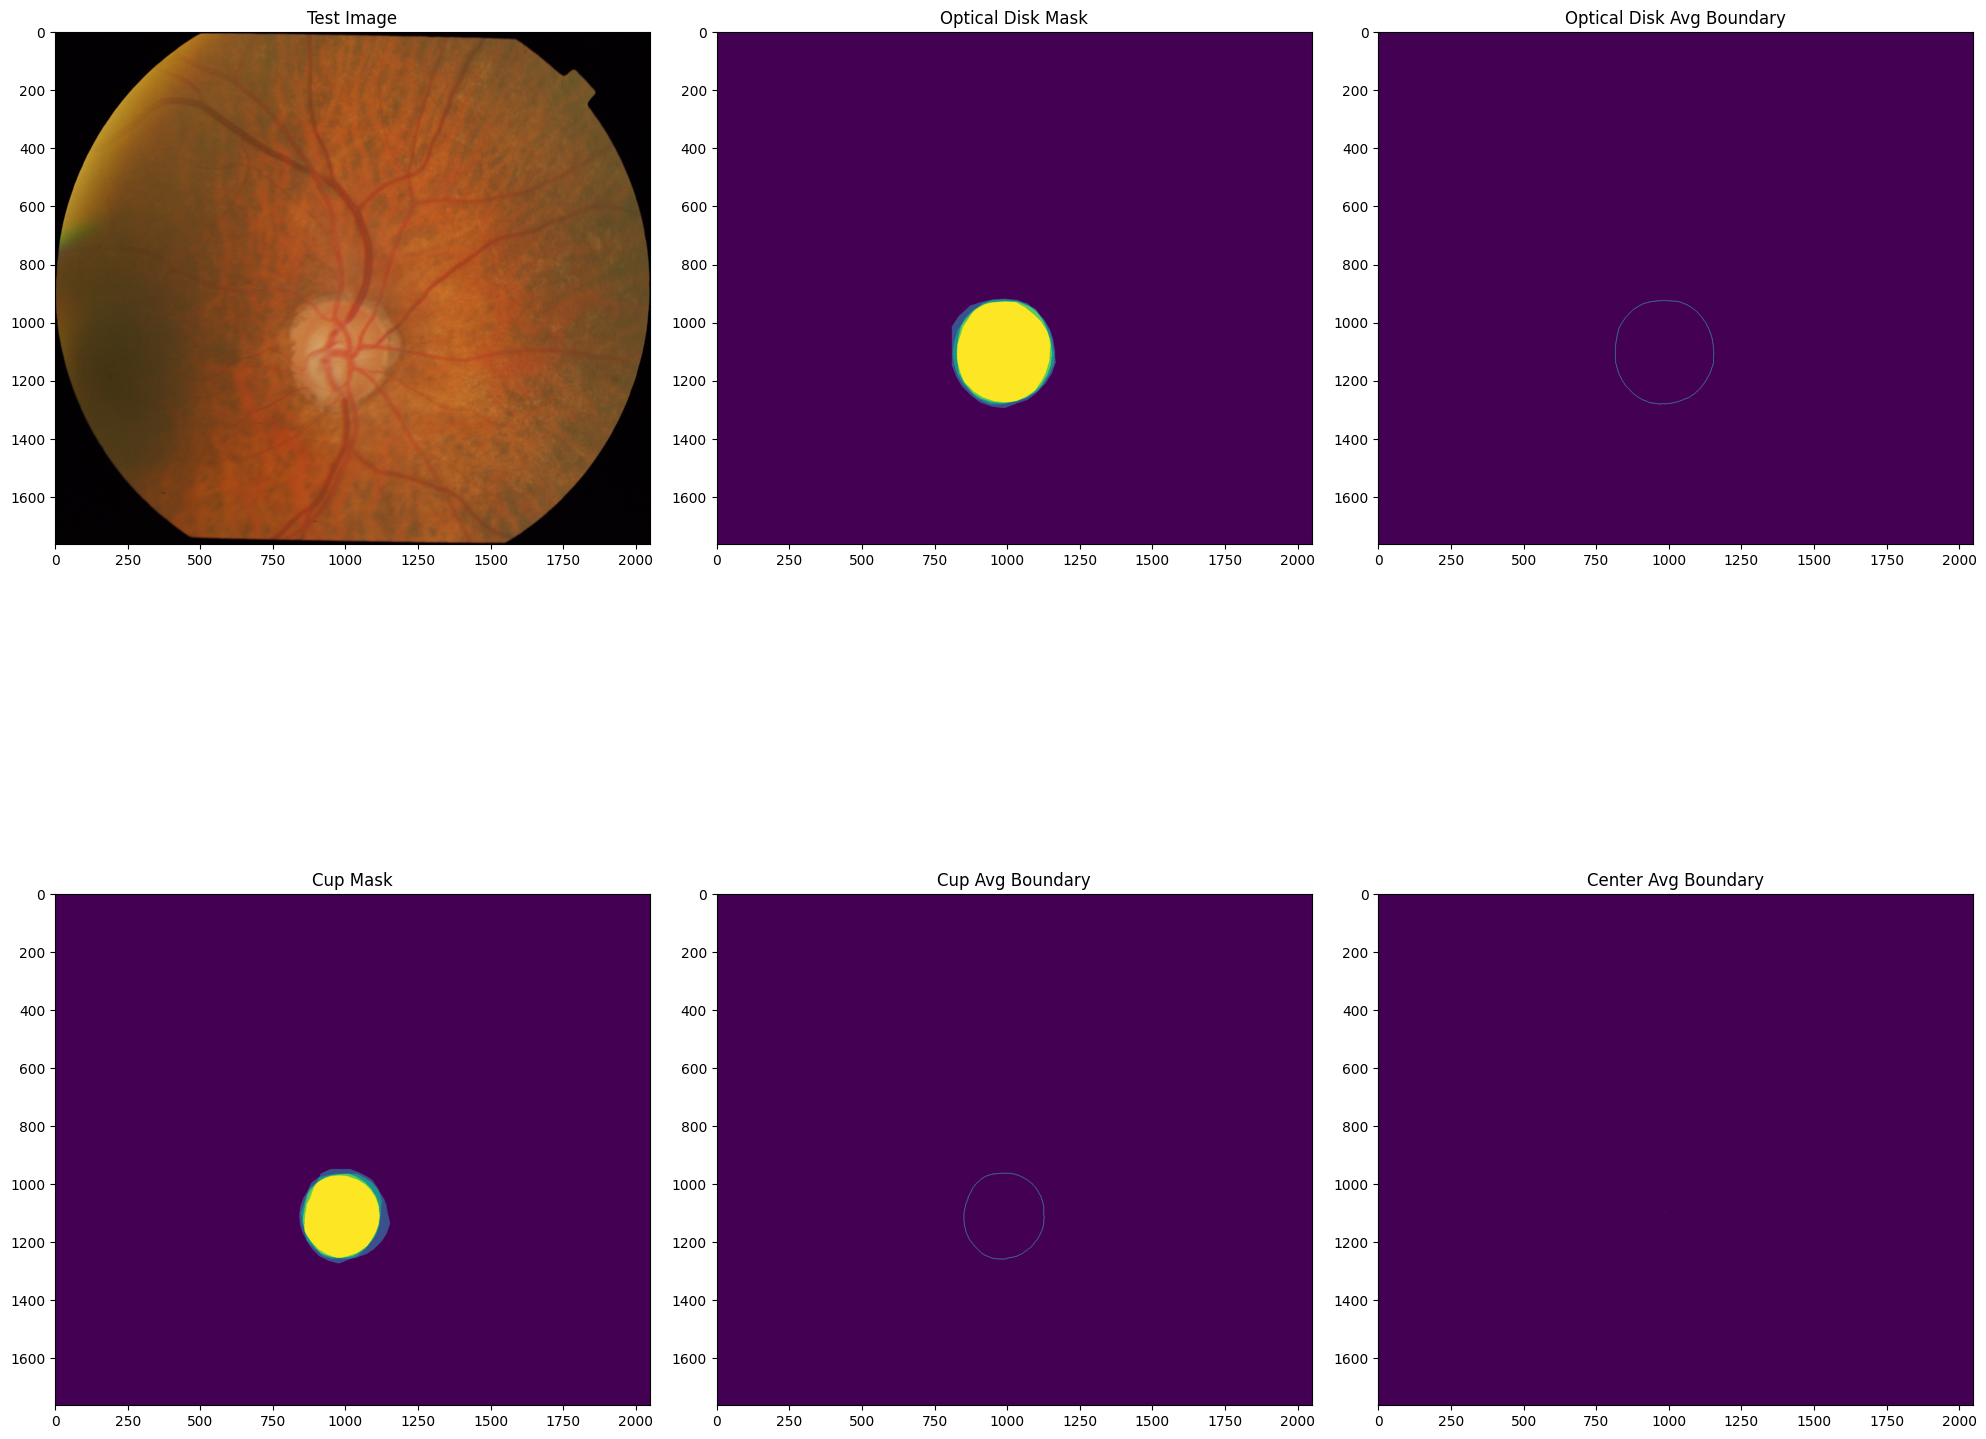

In [9]:
fig, axes = plt.subplots(2, 3, figsize = (20, 20))
axes = axes.flatten()

axes[0].imshow(image)
axes[0].set_title('Test Image')
axes[1].imshow(od)
axes[1].set_title('Optical Disk Mask')
axes[2].imshow(od_mask)
axes[2].set_title('Optical Disk Avg Boundary')
axes[3].imshow(cup)
axes[3].set_title('Cup Mask')
axes[4].imshow(cup_mask)
axes[4].set_title('Cup Avg Boundary')
axes[5].imshow(center_mask)
axes[5].set_title('Center Avg Boundary')
plt.tight_layout()

In [10]:
train_images = np.concatenate([TRAIN_NORMAL_IMAGES, TRAIN_GLAUCOMA_IMAGES])
test_images = np.concatenate([TEST_NORMAL_IMAGES, TEST_GLAUCOMA_IMAGES])

train_ds_dice = Dataset.from_tensor_slices(train_images)\
    .shuffle(buffer_size = SHUFFLE_BUFFER)\
    .map(lambda x: load_image_with_masks(x, dice = True), num_parallel_calls = AUTOTUNE)\
    .map(lambda image, targets: augment_images(image['image'], targets['od'], targets['cup']))\
    .batch(batch_size = BATCH_SIZE)\
    .prefetch(1)\
    .cache()

train_ds_no_dice = Dataset.from_tensor_slices(train_images)\
    .shuffle(buffer_size = SHUFFLE_BUFFER)\
    .map(lambda x: load_image_with_masks(x, dice = False), num_parallel_calls = AUTOTUNE)\
    .map(lambda image, targets: augment_images(image['image'], targets['od'], targets['cup']))\
    .batch(batch_size = BATCH_SIZE)\
    .prefetch(1)\
    .cache()

test_ds_dice = Dataset.from_tensor_slices(test_images)\
    .map(lambda x: load_image_with_masks(x, dice = True, test = True), num_parallel_calls = AUTOTUNE)\
    .batch(batch_size = BATCH_SIZE)

test_ds_no_dice = Dataset.from_tensor_slices(test_images)\
    .map(lambda x: load_image_with_masks(x, dice = False, test = True), num_parallel_calls = AUTOTUNE)\
    .batch(batch_size = BATCH_SIZE)

In [11]:
train_ds_no_dice_st = Dataset.from_tensor_slices(train_images)\
    .shuffle(buffer_size = SHUFFLE_BUFFER)\
    .map(lambda x: load_image_with_masks(x, dice = False), num_parallel_calls = AUTOTUNE)\
    .map(lambda image, targets: augment_images(image['image'], targets['od'], targets['cup'], single_target = True))\
    .batch(batch_size = BATCH_SIZE)\
    .prefetch(1)\
    .cache()

test_ds_no_dice_st = Dataset.from_tensor_slices(test_images)\
    .map(lambda x: load_image_with_masks(x, dice = False, test = True), num_parallel_calls = AUTOTUNE)\
    .map(lambda image, targets: (image['image'], targets['od']))\
    .batch(batch_size = BATCH_SIZE)

In [12]:
def upsampling_block(inp, skips, filters, kernels, rates):
    '''
    Creates a block for upsampling
    Doubles the image dimensions
    And adds the skip connection
    '''   
    activation = 'relu'
    x = inp  
    for f, kernel, skip, rate in zip(filters, kernels, skips, rates):
        x = UpSampling2D()(x)
        x = Conv2D(filters = f, kernel_size = kernel, strides = 1, activation = activation, padding = 'same')(x)
        x = concatenate([x, skip])
        x = BatchNormalization()(x)
        x = SpatialDropout2D(rate = rate)(x)
    return x

def conv_block(inp, filters, kernels, strides, rates):
    '''
    Builds a convulitional block
    When the strides reach 2
    Keeps the output of the last
    Conv layer to be used
    For a skip connection
    '''

    activation = 'relu'
    x = inp
    skips = []
    for f, kernel, stride, rate in zip(filters, kernels, strides, rates):
        if stride == 2:
            skips.append(skip)
            x = MaxPool2D()(x)
            x = Conv2D(filters = f, kernel_size = kernel, strides = 1, activation = activation, padding = 'same')(x)
            skip = x
        else:
            x = Conv2D(filters = f, kernel_size = kernel, strides = 1, activation = activation, padding = 'same')(x)
            skip = x
        
        x = BatchNormalization()(x)
        x = SpatialDropout2D(rate = rate)(x)
    
    return skips, x

In [13]:
def res_unet(conv_filters, conv_kernels, conv_strides, conv_rates, up_filters, up_kernels, up_rates):
    '''
    Builds the u-net structure
    The output is two heads
    One for the Optical Disk
    And another for the cup
    '''
    inp = Input(shape = (*IMAGE_SIZE, 3), name = 'image')
    x = inp
    
    skips, x = conv_block(x, conv_filters, conv_kernels, conv_strides, conv_rates)
    
    skips = skips[::-1]
    
    od = upsampling_block(x, skips, up_filters, up_kernels, up_rates)
    od = Conv2D(filters = 1, kernel_size = 1, strides = 1, padding = 'same', activation = 'sigmoid', name = 'od')(od)
    
    cup = upsampling_block(x, skips, up_filters, up_kernels, up_rates)
    cup = Conv2D(filters = 1, kernel_size = 1, strides = 1, padding = 'same', activation = 'sigmoid', name = 'cup')(cup)
       
    return Model(inputs = inp, outputs = [od, cup])

In [14]:
def res_unet_st(conv_filters, conv_kernels, conv_strides, conv_rates, up_filters, up_kernels, up_rates):
    '''
    Builds the u-net structure
    The output is two heads
    One for the Optical Disk
    And another for the cup
    '''
    inp = Input(shape = (*IMAGE_SIZE, 3), name = 'image')
    x = inp
    
    skips, x = conv_block(x, conv_filters, conv_kernels, conv_strides, conv_rates)
    
    skips = skips[::-1]
    
    od = upsampling_block(x, skips, up_filters, up_kernels, up_rates)
    od = Conv2D(filters = 1, kernel_size = 1, strides = 1, padding = 'same', activation = 'sigmoid', name = 'od')(od)
           
    return Model(inputs = inp, outputs = od)

In [15]:
def dice(y, y_pred):
    '''
    Dice Loss, similar to
    Intersection over Union
    '''
    epsilon = EPSILON
    numerator = 2 * tf.reduce_sum(y * y_pred, axis = [1, 2])
    denominator = tf.reduce_sum(y + y_pred, axis = [1, 2])
    dice = tf.reduce_mean((numerator + epsilon)/(denominator + epsilon))
    return 1 - dice

In [16]:
conv_filters = [8, 16, 32, 64]
conv_kernels = [3, 3, 3, 3]
conv_strides = [1, 2, 2, 2]
conv_rates = [0.8, 0.8, 0.8, 0.8]

upsampling_filters = [32, 16, 8, 8]
upsampling_kernels = [3, 3, 3, 3]
upsampling_rates = [0.5, 0.5, 0.5, 0.5]

mod1 = res_unet(conv_filters, conv_kernels, conv_strides, conv_rates, upsampling_filters, upsampling_kernels, upsampling_rates)
mod1.compile(optimizer = 'Adam', loss = {'od' : dice, 'cup' : dice}, metrics = ['accuracy'])

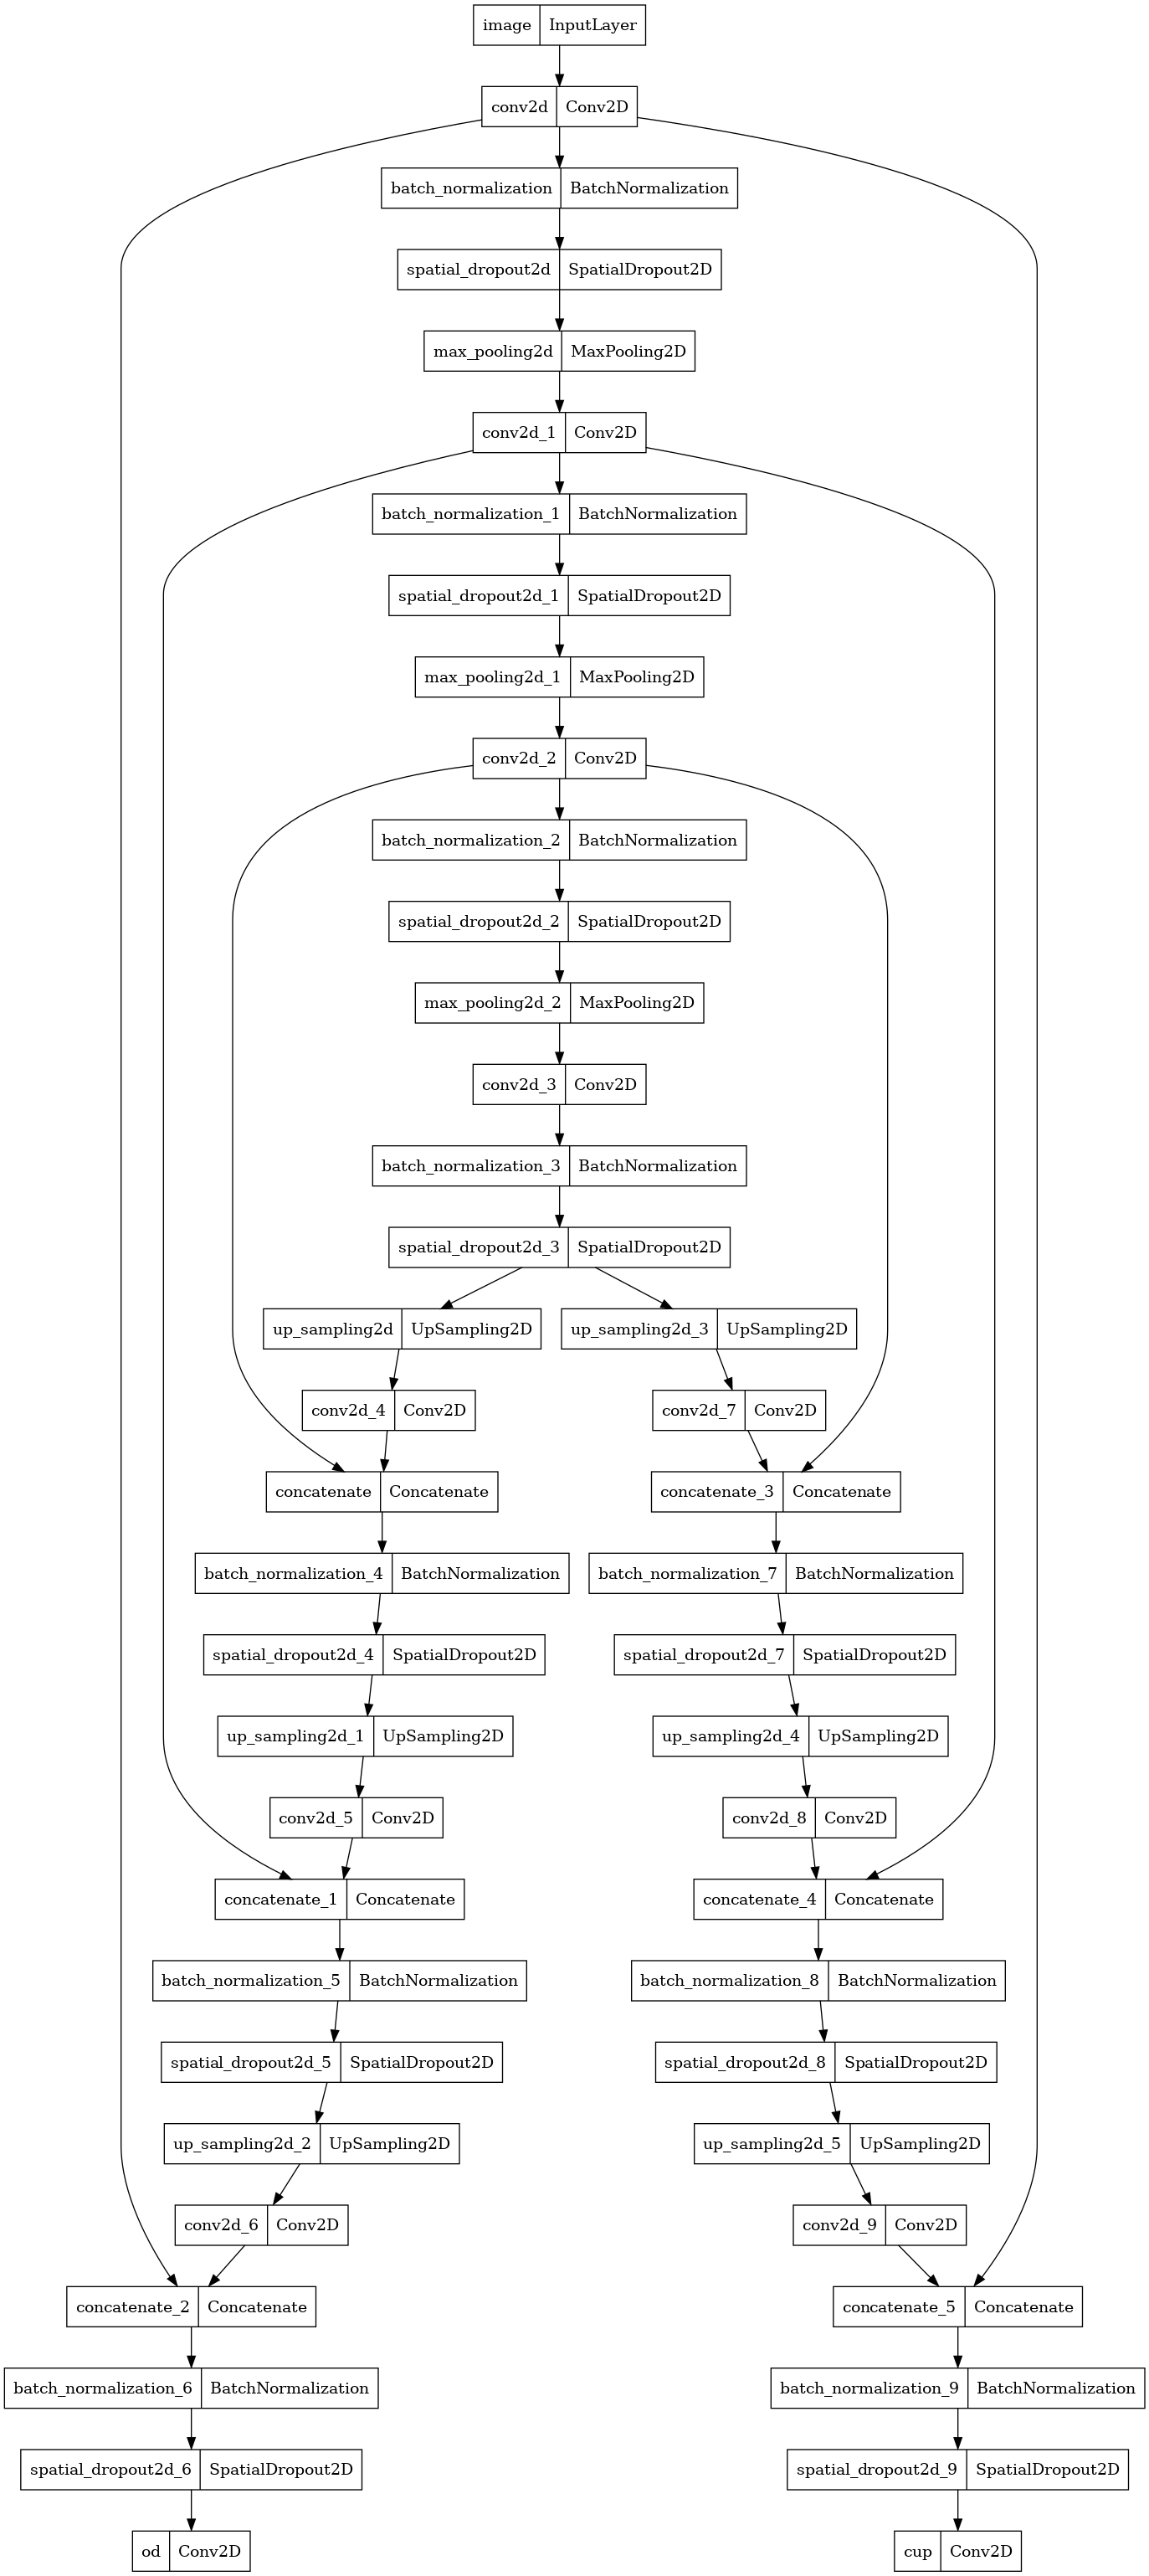

In [17]:
plot_model(mod1)

In [18]:
hist1 = mod1.fit(train_ds_dice, validation_data = test_ds_dice, callbacks = [early_stopping], epochs = 200)

Epoch 1/200


2023-09-15 14:50:26.650549: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/spatial_dropout2d/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2/2 [==============================] - 36s 11s/step - loss: 1.9009 - od_loss: 0.9312 - cup_loss: 0.9696 - od_accuracy: 0.5126 - cup_accuracy: 0.4873 - val_loss: 1.9057 - val_od_loss: 0.9394 - val_cup_loss: 0.9663 - val_od_accuracy: 0.6801 - val_cup_accuracy: 0.9816
Epoch 2/200
2/2 [==============================] - 4s 4s/step - loss: 1.8858 - od_loss: 0.9189 - cup_loss: 0.9668 - od_accuracy: 0.5823 - cup_accuracy: 0.5583 - val_loss: 1.9052 - val_od_loss: 0.9390 - val_cup_loss: 0.9663 - val_od_accuracy: 0.9223 - val_cup_accuracy: 0.9827
Epoch 3/200
2/2 [==============================] - 5s 4s/step - loss: 1.8900 - od_loss: 0.9233 - cup_loss: 0.9666 - od_accuracy: 0.5531 - cup_accuracy: 0.5522 - val_loss: 1.9047 - val_od_loss: 0.9385 - val_cup_loss: 0.9662 - val_od_accuracy: 0.9630 - val_cup_accuracy: 0.9827
Epoch 4/200
2/2 [==============================] - 4s 4s/step - loss: 1.8845 - od_loss: 0.9185 - cup_loss: 0.9660 - od_accuracy: 0.5826 - cup_accuracy: 0.5711 - val_loss: 1.9041 - va

In [19]:
mod2 = res_unet(conv_filters, conv_kernels, conv_strides, conv_rates, upsampling_filters, upsampling_kernels, upsampling_rates)
mod2.compile(optimizer = 'Adam', loss = {'od' : 'binary_crossentropy', 'cup' : 'binary_crossentropy'}, metrics = ['accuracy'])
hist2 = mod2.fit(train_ds_no_dice, validation_data = test_ds_no_dice, callbacks = [early_stopping], epochs = 100)

Epoch 1/100


2023-09-15 14:54:03.235686: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/spatial_dropout2d_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2/2 [==============================] - 17s 5s/step - loss: 1.7801 - od_loss: 0.9348 - cup_loss: 0.8453 - od_accuracy: 0.4559 - cup_accuracy: 0.4965 - val_loss: 1.4888 - val_od_loss: 0.7522 - val_cup_loss: 0.7366 - val_od_accuracy: 0.1584 - val_cup_accuracy: 0.1467
Epoch 2/100
2/2 [==============================] - 4s 4s/step - loss: 1.9160 - od_loss: 0.9965 - cup_loss: 0.9195 - od_accuracy: 0.5045 - cup_accuracy: 0.4794 - val_loss: 1.4933 - val_od_loss: 0.7628 - val_cup_loss: 0.7304 - val_od_accuracy: 0.1748 - val_cup_accuracy: 0.1588
Epoch 3/100
2/2 [==============================] - 5s 5s/step - loss: 1.9865 - od_loss: 1.0311 - cup_loss: 0.9554 - od_accuracy: 0.4545 - cup_accuracy: 0.4687 - val_loss: 1.4913 - val_od_loss: 0.7639 - val_cup_loss: 0.7274 - val_od_accuracy: 0.1792 - val_cup_accuracy: 0.1645
Epoch 4/100
2/2 [==============================] - 6s 5s/step - loss: 1.9106 - od_loss: 0.9675 - cup_loss: 0.9431 - od_accuracy: 0.4649 - cup_accuracy: 0.4545 - val_loss: 1.4834 - val

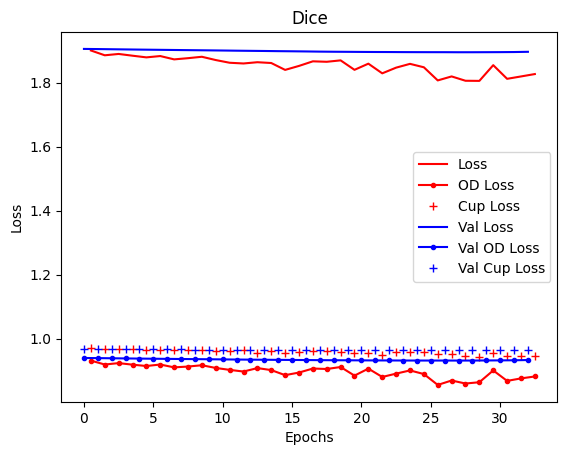

In [20]:
def plot_loss(epochs, hist, loss):
    '''
    Shows the loss metrics
    Uses a more fair comparison
    Between Val and Train
    By shifting the train loss
    an epoch later
    (Train loss is also hurt
    by the dropout layers)
    '''
    plt.plot(epochs + .5, hist.history['loss'], 'r', label = 'Loss')
    plt.plot(epochs + .5, hist.history['od_loss'], 'r.-', label = 'OD Loss')
    plt.plot(epochs + .5, hist.history['cup_loss'], 'r+', label = 'Cup Loss')
    plt.plot(epochs, hist.history['val_loss'], 'b', label = 'Val Loss')
    plt.plot(epochs, hist.history['val_od_loss'], 'b.-', label = 'Val OD Loss')
    plt.plot(epochs, hist.history['val_cup_loss'], 'b+', label = 'Val Cup Loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(loss)


epochs1 = np.arange(0, len(hist1.history['loss']))
plot_loss(epochs1, hist1, 'Dice')

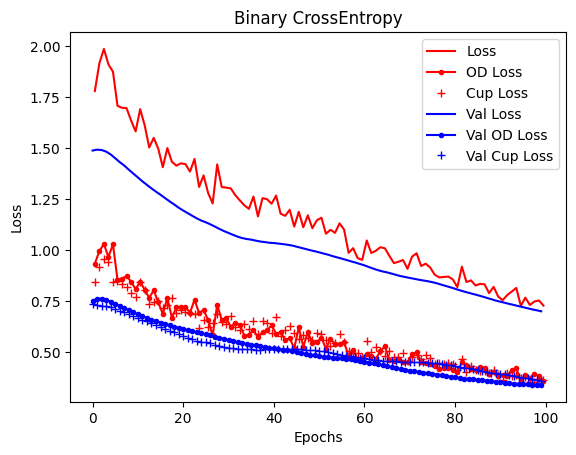

In [21]:
epochs2 = np.arange(0, len(hist2.history['loss']))
plot_loss(epochs2, hist2, 'Binary CrossEntropy')